<a href="https://colab.research.google.com/github/miloszp2223/ZadanieML/blob/master/Lista4ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo # do funkcji summary

In [ ]:
import numpy as np
import torch
from scipy.signal import convolve2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from torch import optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import copy
import random
import matplotlib.pyplot as plt
from torch.utils.data import random_split



### Jak zrobić zadanie

Notebook składa się z 4 zadań, jednak **najważniejsze są zadania 3 i 4**, bo dotyczą stricte własnej implementacji sieci konwolucyjnej. W poszczególnych sekcjach znajdują się opisy które powinny wystarczyć do zrozumienia i implementacji, ale poniżej zamieszczone są źródła do dalszej nauki.

Zbiorem danych będzie *FashionMNIST* lub *CIFAR10* (w zależności od waszej preferencji).

Źródła
- https://visionbook.mit.edu/convolutional_neural_nets.html -> na pograniczu CV i CNN
- https://engineering.purdue.edu/DeepLearn/pdf-kak/DemystifyConvo.pdf -> przydatne do zadania z konwolucją
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks#layer -> wizualizacje
- https://guandi1995.github.io/Padding/ -> objaśnienie paddingu
- https://cs231n.github.io/convolutional-networks/ -> kurs od stanford
- warstwy w PyTorch: [Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [MaxPool2d
](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), [BatchNorm2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d), [Dropout2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#torch.nn.Dropout2d)


### 0. Po co nam coś więcej niż MLP?

Na poprzedniej liście spłaszczaliśmy obrazki, aby móc je przepuścić przez sieć FNN, jednak taki preprocessing do formy tabelarycznej gubi istotne informacje. Po pierwsze, piksele blisko siebie w oryginalnym obrazie mogą znaleźć się daleko od siebie, dodatkowo wszystkie piksele będą "wymieniać" się sygnałami z wszystkimi innymi pikselami. Jest to mechanizm dosyć nieefektywny (w szarym obrazku o rozmiarze 128x128 mamy na wejściu już 16 384 cech!) i tu na pomoc przychodzą konwolucje.

### 1. Konwolucja

Podstawową operację konwolucji jest lepiej sobie zobrazować (pun intended) na podstawie jednego, oczywistego przykładu. Załóżmy, że mamy obraz binarny (czyli składający się z 0 i 1). Jest to typowa reprezentacja maski w zadaniu segmentacji - 1 oznacza, że na danym pikselu jest interesujący nas obiekt, a 0 to tło.

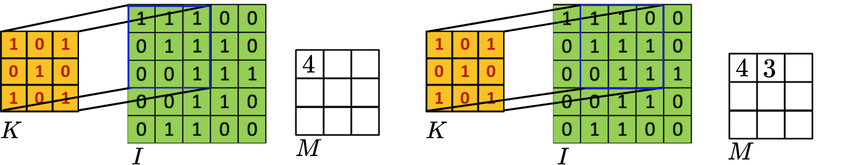

Wyjaśnienie symboli na obrazku
- $I$ - obrazek wejściowy
- $K$ - filtr (kernel) o wymiarze 3x3
- $M$ - wyjściowa mapa cech

Wynik przesuwania się filtra po wejściowej mapie można opisać wzorem

$$(K ⋆ I)(i, j) = \sum_{a=0}^{H_k-1}\sum_{b=0}^{W_k-1} K(a, b)I(i + a, j + b)$$

opisuje to jaki będzie wynik w pikselu o współrzędnych (i, j) w wynikowej mapie $M$. $H_k$ i $W_k$ oznaczają odpowiednio wysokość i szerokość filtra - często rozważamy kwadratowe rozmiary, $H_k$ = $W_k$.


(Tak naprawdę wzór wyżej opisuje korelację wzajemną - *cross-correlation*, ponieważ matematyczna operacja konwolucji dałaby wynik obrócony o 180 stopni)

Taka prosta formulacja nie uwzględnia faktu, że obrazki (zwykle) zawierają kanał koloru RGB. W takim razie filtr $K$ ma teraz możliwe współrzędne $K_{a,b,d}$. Wiemy już z poprzednich list, że budująć sieć neuronową chcemy zwiększyć liczbę ukrytych wymiarów. Dlatego też, aby zwiększyć liczbę kanałów z 3 (rgb) na $Q_k$, nasz filtr musi mieć 4 wymiary, więc indeksować się jako $K_{a,b,d,q}$. To oznacza, że mamy $Q_k$ pojedynczych filtrów, które będą przesuwać się po wejściowym obrazku. Ostatecznie konwolucja będzie mieć postać

$$M_{i,j,q} = \sum_{a=0}^{H_k-1}\sum_{b=0}^{W_k-1}\sum_{d=0}^{D_I-1}K(a, b, d, q)I(i + a, j + b, d)$$

Wynikowy rozmiar takiej mapy nie jest domyślnie równy wejściowemu obrazkowi (lub mapie). Wynika to z tego, że musimy wybrać tylko te "kawałki" obrazka, które w pełni mieszczą się w filtrze (później powiemy o paddingu). Zakładając, że obrazki są mają wymiar $H_I \times W_I \times D_I$, kernel $H_k \times W_k \times D_I \times Q_k$ to wynikowy rozmiar ma postać $$(H_I - H_k + 1) \times (W_I - W_k + 1) \times Q_k$$

Przesuwając kolejno filtr o jedną pozycję (jak dalej się dowiemy, krok jaki wykonuje filtr odnosi się do parametru *stride*) obliczamy wynikową mapę. Wartości w mapie $W$ nie są zwykle z góry znane (tym bardziej nie są binarne jak w prostym przykładzie wyżej), ale wyuczane w procesie trenowania sieci.


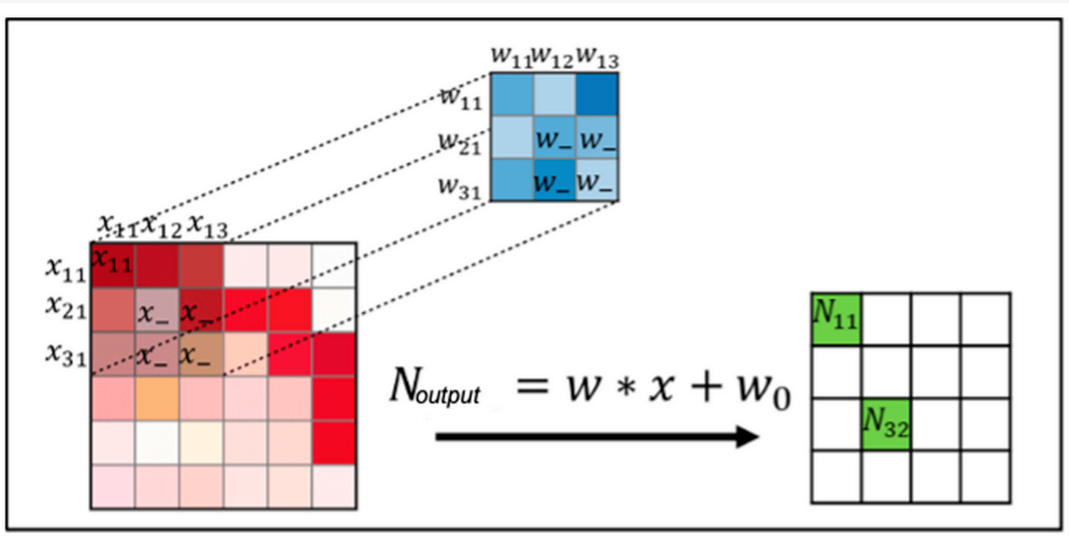

Polecam zajrzeć tutaj po interaktywną wizualizację https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

### Zadanie 1
Bazując na opisie wyżej i wiarygodnych źródłach, napisz własną implementację operacji konwolucji. Może ona opierać się na macierzach NumPy lub PyTorch. Wykorzystaj poniższą linijkę z testami, aby sprawdzić swoje rozwiązanie.

Ekstra: pomyśl, czy dałoby się zapisać taką operację czysto w sposób macierzowy, pozbywając się pętli (lub chociaż ograniczając ich liczbę).

*Ekstra: pomyśl o dodaniu paddingu (może być to wartość 0), aby mapa wyjściowa była równa rozmiarowo wejściu (wtedy też musisz zmienić padding w testach).

In [ ]:
def convolution_old(X, K, q: int):
  '''
  Wykonuje operację konwolucji na wejściowym obrazie *X* oraz filtrze *K*. Zwraca wynikową mapę.
  Args:
    X: numpy / torch tensor o wymiarach (h, w, d)
    K: numpy / torch tensor o wymiarach (k, k, d, q)
    q: liczba filtrów
  '''




  # TO JEST FEJKOWA IMPLEMENTACJA - USUŃ TO I PISZ KOD TUTAJ
  h_in, w_in, d_in = X.shape
  k_h, k_w, k_d, c_out = K.shape




  h_out = h_in - k_h + 1
  w_out = w_in - k_w + 1

  result = torch.zeros((h_out, w_out, c_out), device=X.device)

  for c in range(c_out):
    for i in range(h_out):
      for j in range(w_out):
        val = 0
        for d in range(k_d):
          for m in range(k_h):
            for n in range(k_w):
              val += X[i + m][j + n][d] * K[m][n][d][c]
        result[i][j][c] = val
        #for k in range(c_out):


  return torch.tensor(result)  # może być torch.Tensor


def convolution(X, K, q: int, padding=0):
  '''
  Wykonuje operację konwolucji na wejściowym obrazie *X* oraz filtrze *K*. Zwraca wynikową mapę.
  Args:
    X: numpy / torch tensor o wymiarach (h, w, d)
    K: numpy / torch tensor o wymiarach (k, k, d, q)
    q: liczba filtrów
  '''

  if padding>0:
    X = X.permute(2,0,1)           # (C,H,W)
    X = F.pad(X, (padding,padding,padding,padding))
    X = X.permute(1,2,0)           # (H,W,C)


  h_in, w_in, d_in = X.shape
  k_h, k_w, k_d, c_out = K.shape


  h_out = h_in - k_h + 1
  w_out = w_in - k_w + 1

  result = torch.zeros((h_out, w_out, c_out), device=X.device)

  for i in range(h_out):
    for j in range(w_out):
        patch = X[i:i+k_h, j:j+k_w, :]          # (k,k,d)
        result[i, j] = (patch[..., None] * K).sum(dim=(0,1,2))



  return torch.tensor(result)  # może być torch.Tensor




#### Przypadki testowe
Nie musisz nic tutaj modyfikować z wyjątkiem gdy używasz NumPy (w kodzie są zaznaczone linijki, które trzeba odkomentować)

In [ ]:
def generate_deterministic_tensor(shape, mod_val=5, offset=0):
    count = 1
    for s in shape:
        count *= s
    # Tworzymy sekwencję 0, 1, 2... i bierzemy modulo
    data = torch.arange(count).float() % mod_val + offset
    return data.reshape(shape)

def torch_2_numpy(pt):
  return pt.detach().numpy()

def run_pytorch_test(case_name, img_hwc, kernel_hwcn):
    image_hwc = generate_deterministic_tensor(img_hwc, mod_val=5)
    kernel_hwcn = generate_deterministic_tensor(kernel_hwcn, mod_val=3, offset=-1)

    pad = (kernel_hwcn.shape[0] - 1)//2
    print(f"Input shape (H,W,C): {tuple(image_hwc.shape)}")
    print(f"Kernel shape (H,W,Cin,Cout): {tuple(kernel_hwcn.shape)}")

    # Dodanie wymiaru batcha
    input_tensor = image_hwc.permute(2, 0, 1).unsqueeze(0)
    weights = kernel_hwcn.permute(3, 2, 0, 1)
    output_tensor = F.conv2d(input_tensor, weights, stride=1, padding=pad)
    output_hwc = output_tensor.squeeze(0).permute(1, 2, 0)

    # ODKOMENTUJ JEŚLI twoim inputem jest wielowymiarowa macierz NumPy
    # image_hwc = torch_2_numpy(image_hwc)
    # kernel_hwcn = torch_2_numpy(kernel_hwcn)

    my_output = convolution(image_hwc, kernel_hwcn, kernel_hwcn.shape[-1], padding=pad)
    if isinstance(my_output, np.ndarray):
        my_output = torch.from_numpy(my_output)

    my_output = my_output.to(torch.float64)
    output_hwc = output_hwc.to(torch.float64) # do samego typu żeby nie było błędu

    try:
      torch.testing.assert_close(my_output, output_hwc, rtol=1e-05, atol=1e-08)
      print(f"Test zaliczony")
    except AssertionError as e:
      print(f"Test niezaliczony: {e}")
    print(f"Output shape (H,W,C): {tuple(output_hwc.shape)}")

# --- URUCHOMIENIE PRZYPADKÓW ---

# Przypadek 1: Mały
run_pytorch_test("PRZYPADEK 1", (6, 6, 3), (3, 3, 3, 5))

# Przypadek 2: Średni
run_pytorch_test("PRZYPADEK 2", (12, 12, 3), (3, 3, 3, 5))

# Przypadek 3: Projekcja 1x1
run_pytorch_test("PRZYPADEK 3", (24, 24, 3), (1, 1, 3, 10))

Input shape (H,W,C): (6, 6, 3)
Kernel shape (H,W,Cin,Cout): (3, 3, 3, 5)
Test zaliczony
Output shape (H,W,C): (6, 6, 5)
Input shape (H,W,C): (12, 12, 3)
Kernel shape (H,W,Cin,Cout): (3, 3, 3, 5)
Test zaliczony
Output shape (H,W,C): (12, 12, 5)
Input shape (H,W,C): (24, 24, 3)
Kernel shape (H,W,Cin,Cout): (1, 1, 3, 10)
Test zaliczony
Output shape (H,W,C): (24, 24, 10)


/tmp/ipython-input-2806257318.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(result)  # może być torch.Tensor


### 2. Porównanie konwolucji i sieci w pełni połączonej

| Cecha | Konwolucja (CNN) | Sieć w pełni połączona (FNN / Dense) |
| :--- | :--- | :--- |
| **1. Wagi/Parametry** | **Współdzielone (Parameter Sharing)**<br>Ten sam zestaw wag (filtr) jest używany do skanowania całego obrazu | **Indywidualne**<br>Każde połączenie ma własną wagę przypisaną do konkretnego piksela/pozycji na wejściu |
| **2. Zasięg działania** | **Lokalny**<br>Operacja dotyczy tylko małego wycinka (okna) wokół aktualnie przetwarzanego punktu | **Globalny**<br>Każdy neuron w warstwie ukrytej "widzi" i jest połączony ze wszystkimi pikselami obrazu wejściowego |
| **3. Przesunięcie obiektu** | **Ekwiwariancja na translację**<br>Jeśli obiekt (np. kot) przesunie się na obrazie, sieć nadal go wykryje (tylko w innym miejscu mapy cech) | **Wrażliwość na pozycję**<br>Sieć musi "nauczyć się" wyglądu kota w każdym możliwym położeniu osobno, traktując je jako zupełnie nowe wzorce |
| **Efektywność** | Mniejsza liczba parametrów (dzięki współdzieleniu wag), szybsze uczenie obrazów | Ogromna liczba parametrów przy dużych obrazach, wysokie ryzyko przeuczenia |

### 3. Pole recepcyjne

Po angielsku *receptive field* odnosi się do wszystkich możliwych miejsc na obrazku, jak i na poprzednich mapach, które mogą wpływać na wynik w aktualnie rozważanym elemencie. Lepiej to obrazuje załączony schemat, gdzie widzimy jak element po środku tak naprawdę posiada informacje z poprzednich warstw. Jest to główna koncepcja w kontekście projektowania architektur konwolucyjnych sieci neuronowych, gdzie głębsze warstwy uczą się bardziej skomplikowanych struktur bazując na prymitywnych kształtach zidentyfikowanych na niższych warstwach.

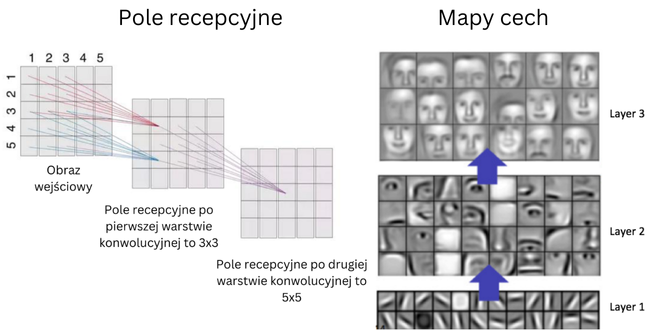

### 4. Operacja Poolingu

Aby jeszcze bardziej zmniejszyć rozmiar wynikowej mapy (tj. jej szerokość i wysokość) stosuje się operacje *max* lub *avg* pooling. Działają one w ten sposób, że na każdym rozłącznym kawałku wejściowego obrazka/mapy wykonujemy pewną redukcję do jednej wartości wyjściowej. Przypomina to operację konwolucji, natomiast nie mamy tutaj żadnych wag kernela, tylko z góry deterministyczną operację. Zastosowanie poolingu na kawałkach $2 \times 2$ zmniejsza wejściowy tensor dwukrotnie (dla $3 \times 3 $ zmniejszy trzykrotnie, i tak dalej). Zdecydowanie bardziej popularny jest **max pooling**, ponieważ przypomina wyciąganie tej najbardziej istotnej informacji z obrazka.

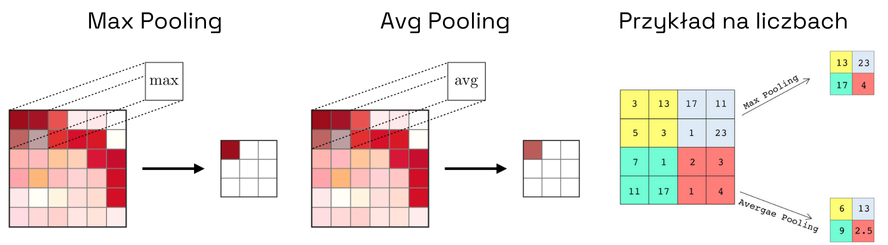

$$M(i, j) = \max_{(a, b) \in 𝒩} I(a, b) ← \text{max pooling} $$  
$$M(i, j) = \frac{1}{|𝒩|} \sum_{(a, b) \in 𝒩} I(a, b)  ← \text{avg pooling}$$

gdzie
- $I$ - wejściowy obrazek lub mapa
- $M$ - wyjściowa mapa
- $𝒩$ - fancy matematyczny znaczek na określenie sąsiedztwa, a w praktyce to zbiór wszystkich pozycji na wejściu $(a, b)$ które są aktualnie w rozważanym obszarze $n \times n$

#### Global Average Pooling

Ważną operacją bezpośrednio przydatną gdy będziemy implementować sieć CNN jest ekstremalna wersja poolingu, która przyjmuje mapę o wymiarze $H \times W \times C$ i zwraca wektor o długości $C$ (Tj. dla każdego kanału $c$ oblicza średnią po $H$ i $W$). Zwykle ta warstwa stanowi pomost między częścią konwolucyjną sieci a częścią w pełni połączoną (FFN).

### 5. Warstwa konwolucji w PyTorch
Zanim zaczniemy budować sieć składającą się z wielu warstw konwolucji, to warto zrozumieć jakie przyjmuje ona (najistotniejsze) parametry

```
class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

- in_channels - liczba filtrów w wejściowej mapie/obrazku. Będzie to 3 dla obrazu RGB, a dla pośrednich map to będzie zależeć od liczby *out_channels* poprzedniej warstwy
- out_channels - liczba filtrów wyjściowych mapy (a jednocześnie liczba filtrów wejściowych do kolejnej warstwy konwolucyjnej)
- kernel_size - tuple (wysokość, szerokość) lub skalar dla kwadratowego filtra, od tej wielkości zależy też wysokość i szerokość wynikowej mapy
- stride - domyślnie 1, określa o ile pikseli przesuwamy się filtrem w każdym kolejnym kroku. Wybranie wartości > 1 ma podobny wpływ jak zastosowanie poolingu
- padding - domyślnie brak, określa jaka jest szerokość ramki, która jest dodawana do wejściowej mapy. Jest to przydatne kiedy chcemy, żeby wielkość wynikowej mapy była równa mapie wejściowej - wtedy podajemy jako wartość 'same' (tylko dla $stride = 1$)
- dilation - domyślnie 1, określa w obrębie samego filtra jaki jest odstęp między pikselami mapy wejściowej
- bias - oznacza to samo co dla warstwy liniowej, może być konieczne ustawienie na *False*

`kernel_size`, `stride`, `padding` i `dilation` mogą być typu `int` dla kwadratowych obszarów, lub `tuple` do określenia oddzielnie wysokości i szerokości

Wzór na wysokość ($H$) i szerokość ($W$) wyjściową ma postać
$$H_{out} = ⌊ \frac{H_{in} + 2 \times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1}{stride[0]} + 1⌋$$

$$W_{out} = ⌊ \frac{W_{in} + 2 \times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1}{stride[1]} + 1⌋$$

(symbol "podłogi" $⌊$, $⌋$ oznacza zaokrąglenie w dół do liczby całkowitej)

dla kwadratowego wejścia i filtrów upraszcza się to do $H_{out} = W_{out}$



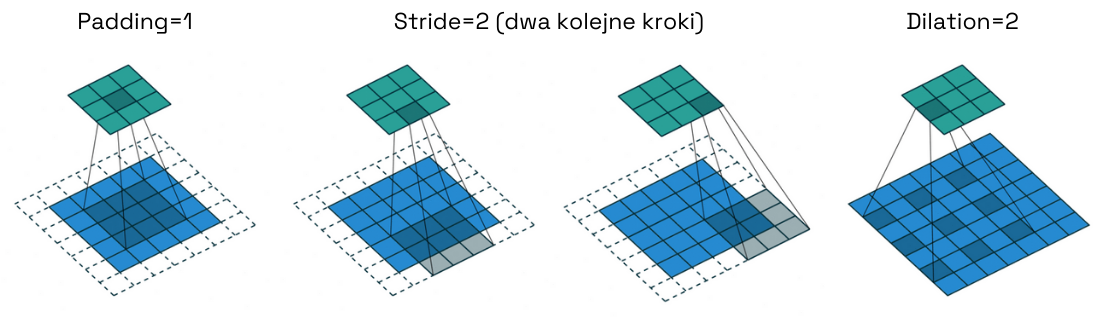

### Zadanie 2
Na podstawie wyżej wyjaśnionych argumentów i wzorów uzupełnij poniżej brakujące wartości. Nie musisz nad tym spędziać nie wiadomo ile czasu, ale warto nabrać intuicji które parametry musisz zmienić i jakie powinny być wartości by uzyskać zamierzoną wyjściową wielkość.

**Uwaga** zgodnie z konwencją Pytorcha, kolejność wymiarów po kolei to ($B$, $D$, $H$, $W$), tak więc wymiar kanału znajduje się nie na końcu, lecz na początku każdego obrazka/mapy. $B$ to batch size równy 1 tutaj.

In [ ]:
def validate_layer(case_name, layer, input_shape, expected_shape):
    print(f"--- {case_name} ---")
    print(f"Input: {input_shape}")

    # Tworzymy losowy tensor z batch=1
    x = torch.randn(1, *input_shape)

    try:
        y = layer(x)
        out_shape = tuple(y.shape)[1:] # bez batch

        print(f"Oczekiwany kształt: {expected_shape}")
        print(f"Twój kształt:       {out_shape}")

        if out_shape == expected_shape:
            print("OK. \n")
        else:
            print("Błąd: Kształty się nie zgadzają.\n")

    except Exception as e:
        print(f"Jakiś błąd: {e}\n")

# -------- TEST CASES ---------------

# PRZYPADEK 1: Agresywna redukcja (styl pierwszej warstwy AlexNet)
# Wejście: 224x224 (obraz)
# Wyjście: 55x55
# Wymagane: Użyj Padding=2. Resztę dobierz.
# Wskazówka: Kernel jest duży (>7), a krok (stride) też jest spory (>2).
case_1 = nn.Conv2d(
    in_channels=3,
    out_channels=64,
    padding=2,
    dilation=1,
    # --- DO UZUPEŁNIENIA ---
    kernel_size=9,  # <-- zmień to
    stride=4        # <-- zmień to
)


# Test 1
validate_layer("PRZYPADEK 1: Redukcja 224 -> 55", case_1,
                input_shape=(3, 224, 224),
                expected_shape=(64, 55, 55))

# PRZYPADEK 2: Asymetryczna konwolucja
# Wejście: 32x32
# Wyjście: 30x16
# Wymagane: Padding=0.
# Wskazówka: Wysokość (32->30) maleje wolno, Szerokość (32->16) maleje szybko.
# Użyj krotki (tuple) dla kernel_size i stride, np. (h, w).
case_2 = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    padding=0,
    dilation=1,
    # --- DO UZUPEŁNIENIA ---
    kernel_size=(3, 1), # <-- zmień to
    stride=(1, 2)       # <-- zmień to
)

# Test 2
validate_layer("PRZYPADEK 2: Prostokątne okna 32 -> 30x16", case_2,
                input_shape=(1, 32, 32),
                expected_shape=(1, 30, 16))


# PRZYPADEK 3: "Dziurawy" Kernel (Dilated Convolution)
# Wejście: 50x50
# Wyjście: 46x46
# Wymagane: Stride=1, Padding=0. Kernel ma rozmiar 3x3.
# Zastanów się jak to możliwe, że kernel (3, 3) zmniejsza wielkość aż o 4 piksele?
case_3 = nn.Conv2d(
    in_channels=16,
    out_channels=16,
    stride=1,
    padding=0,
    kernel_size=3,
    # --- DO UZUPEŁNIENIA ---
    dilation=2  # <-- zmień to
)


# Test 3
validate_layer("PRZYPADEK 3: Dylatacja 50 -> 46", case_3,
                input_shape=(16, 50, 50),
                expected_shape=(16, 46, 46))

--- PRZYPADEK 1: Redukcja 224 -> 55 ---
Input: (3, 224, 224)
Oczekiwany kształt: (64, 55, 55)
Twój kształt:       (64, 55, 55)
OK. 

--- PRZYPADEK 2: Prostokątne okna 32 -> 30x16 ---
Input: (1, 32, 32)
Oczekiwany kształt: (1, 30, 16)
Twój kształt:       (1, 30, 16)
OK. 

--- PRZYPADEK 3: Dylatacja 50 -> 46 ---
Input: (16, 50, 50)
Oczekiwany kształt: (16, 46, 46)
Twój kształt:       (16, 46, 46)
OK. 



### 6. Architektura sieci konwolucyjnej

Głębokie sieci konwolucyjne składają się z warstw konwolucyjnych przeplatanych funkcjami aktywacji (zwykle ReLU), operacjami Poolingu, oraz odpowiednikami w 2D Batch Normalization i Dropout (niekoniecznie w tej kolejności). Wraz z kolejnymi warstwami powinna rosnąć liczba filtrów (np. 16 -> 32 -> 64 -> 128 itp.) i zmniejszać się wielkość każdej wynikowej mapy (filtry mają zwykle rozmiar 3x3).

Po serii takich warstw musimy znowu wrócić do w pełni połączonych warstw, z tego powodu stosujemy Global Average Pooling. Typowo taka architektura posłuży do zadania klasyfikacji.  



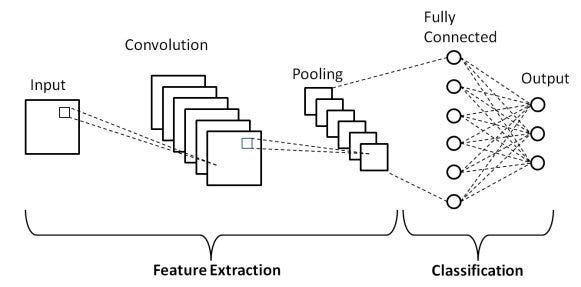

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 8
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # lub użyjcie innej normalizacji jeśli uznacie za prawidłowe
  ])

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)



train_size = 50000
val_size = 10000

trainset, valset = random_split(
    trainset,
    [train_size, val_size]
)

batch_size = 256

train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator().manual_seed(seed)
)

val_loader = DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.54MB/s]


### Zadanie 3

**Zaimplementuj** i **wytrenuj** sieć konwolucyjną do zadania klasyfikacji dla zbioru FashionMNIST lub CIFAR10 (dowolność wyboru) która będzie zawierała następujące elementy
- co najmniej 2 bloki składające się z warstw konwolucyjnych i funkcji aktywacji
- sieci w pełni połączonej (minimalna głębokość to 1) służącej jako klasyfikator (powinno to być łatwe po poprzedniej liście)
- na tym etapie użyj [Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html) do spłaszczenia wymiarów $(B, C, H, W) → (B, C * H * W)$ dla wejścia do warswty liniowej

posłuży ona jako baseline do dalszych eksperymentów. Jeśli dysponujesz siecią FNN z poprzedniej listy, to możesz też odnieść się do jej wyników (nie musisz jej tutaj kopiować i na nowo trenować).

Przebieg trenowania dla sieci konwolucyjnej jest praktycznie taki sam jak do sieci z poprzedniego zadania, tylko że nie spłaszczamy obrazków na wejściu (m. in).

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # lub użyjcie innej normalizacji jeśli uznacie za prawidłowe
  ])

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```
**Zwizualizuj** krzywe uczenia tak jak na poprzednich listach i odpowiednie metryki (np. *f1-score* lub *accuracy*)

In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(
        self,
        pooling=nn.MaxPool2d,
        global_average_pooling=False,
        use_batchnorm=False,
        dilation=1,
        stride=1,
        dropout_p=0.0
    ):
        super().__init__()
        self.global_average_pooling = global_average_pooling

        def BN(c):
            return nn.BatchNorm2d(c) if use_batchnorm else nn.Identity()

        # blok 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1, dilation=dilation, stride=stride),
            BN(8),
            nn.ReLU(),
            pooling(kernel_size=2),
            nn.Dropout2d(dropout_p)
        )

        # blok 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1, dilation=dilation, stride=stride),
            BN(16),
            nn.ReLU(),
            pooling(kernel_size=2),
            nn.Dropout2d(dropout_p)
        )


        if global_average_pooling:
            self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
            self.classifier = nn.Sequential(
                nn.Linear(16, 32),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(32, 10)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(16 * 7 * 7, 32),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(32, 10)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        if self.global_average_pooling:
            x = self.global_avg_pool(x)
            x = x.view(x.size(0), -1)

        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)


In [ ]:
import torch
import torch.nn as nn

class CNN3(nn.Module):
    def __init__(
        self,
        pooling=nn.MaxPool2d,
        global_average_pooling=False,
        use_batchnorm=False,
        dilation=1,
        stride=1,
        dropout_p=0.0
    ):
        super().__init__()
        self.global_average_pooling = global_average_pooling

        def BN(c):
            return nn.BatchNorm2d(c) if use_batchnorm else nn.Identity()

        # blok 1 bez poolingu
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1, dilation=dilation, stride=stride),
            BN(8),
            nn.ReLU(),
            nn.Dropout2d(dropout_p)
        )

        # blok 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1, dilation=dilation, stride=stride),
            BN(16),
            nn.ReLU(),
            pooling(kernel_size=2),
            nn.Dropout2d(dropout_p)
        )

        # blok 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, dilation=dilation, stride=stride),
            BN(32),
            nn.ReLU(),
            pooling(kernel_size=2),
            nn.Dropout2d(dropout_p)
        )

        if global_average_pooling:
            self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
            self.classifier = nn.Sequential(
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(64, 10)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32 * 7 * 7, 64),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(64, 10)
            )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        if self.global_average_pooling:
            x = self.global_avg_pool(x)
            x = x.view(x.size(0), -1)

        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN3().to(device)


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader=None,
    epochs=20,
    lr=0.002,
    patience=5,
    optim_class=optim.Adam,
    device="cuda" if torch.cuda.is_available() else "cpu",
    l1_lambda=0.0,
    l2_lambda=0.0,
    use_cosine_scheduler=False
):

    model.to(device)

    criterion = nn.CrossEntropyLoss()

    # (L2)
    optimizer = optim_class(
        model.parameters(),
        lr=lr,
        weight_decay=l2_lambda if l2_lambda > 0 else 0.0
    )

    scheduler = None
    if use_cosine_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=1e-6
        )


    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "lr": []
    }

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        train_loss = 0.0
        all_preds, all_targets = [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)

            loss = criterion(outputs, y)

            # (L1)
            if l1_lambda > 0:
                l1_penalty = 0.0
                for p in model.parameters():
                    l1_penalty += torch.sum(torch.abs(p))
                loss = loss + l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(all_targets, all_preds)
        train_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
        train_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
        train_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_precision"].append(train_precision)
        history["train_recall"].append(train_recall)
        history["train_f1"].append(train_f1)

        # ===== VALIDATION =====
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            all_preds, all_targets = [], []

            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    loss = criterion(outputs, y)

                    val_loss += loss.item() * x.size(0)
                    _, preds = torch.max(outputs, 1)

                    all_preds.append(preds.cpu())
                    all_targets.append(y.cpu())

            all_preds = torch.cat(all_preds).numpy()
            all_targets = torch.cat(all_targets).numpy()

            val_loss /= len(val_loader.dataset)
            val_acc = accuracy_score(all_targets, all_preds)
            val_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
            val_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
            val_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_precision"].append(val_precision)
            history["val_recall"].append(val_recall)
            history["val_f1"].append(val_f1)

        current_lr = optimizer.param_groups[0]["lr"]
        history["lr"].append(current_lr)

        if val_loader is not None:
            print(
                f"Epoch [{epoch+1}/{epochs}] | "
                f"LR:{current_lr:.6f} | "
                f"Train L:{train_loss:.4f} A:{train_acc:.4f} "
                f"F1:{train_f1:.4f} | "
                f"Val L:{val_loss:.4f} A:{val_acc:.4f} "
                f"F1:{val_f1:.4f}"
            )

            if patience > 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print("Early stopping")
                        model.load_state_dict(best_model_wts)
                        return model, history
        if scheduler is not None:
          scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, history

#=========================================


### Zadanie 4

Przeprowadź następujące eksperymenty:

- Eksperyment 1: Dodaj *Max Pooling* w odpowiednim miejscu po warstwach konwolucyjnych. Porównaj z działaniem *Average Pooling*.

- Eksperyment 2: Dodaj warstwę *Global Average Pooling* zamiast spłaszczania tensora przy pomocy Flatten. (Bazuj na sieci z eksperymentu 1)

- Eksperyment 3: Dodaj *Batch Normalization* i/lub *Dropout* w wersji dla 2D. (Bazuj na sieci z eksperymentu 2 z Max Poolingiem)

- Eksperyment 4: Zwiększ liczbę warstw konwolucyjnych i odpowiednio dobierz liczbę filtrów. (Bazuj na sieci z eksperymentu 3)

- Eksperyment 5: Zmień co najmniej 2 wartości domyślne parametrów z listy: `stride`, `dilation`, `padding`. Dlaczego wybrałeś/aś takie parametry i jak poskutkowało ich dodanie? (np. sieć jest mniejsza; wynikowa mapa przed global avg pooling jest mniejsza;)

Po każdej nowej wersji modelu zbadaj jego wielkość

```
summary(model, input_size=(1, 3, 32, 32)) # model to instancja sieci, a obrazki są np. 1x28x28 (MNIST) lub 3x32x32 (CIFAR)
```

Pamiętaj, żeby nie pisać na nowo (bądź kopiować) pętli do trenowania - zwiększy to czytelność notebooka. Również może być pomocna parametryzacja modelu zamiast tworzenie nowej klasy dla każdego eksperymentu z osobna ([ModuleList](https://docs.pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) łączy warstwy w liście wejściowej). **Udokumentuj przebieg eksperymentów** w postaci porównania wybranych metryk i/lub krzywych uczenia.


In [ ]:
def plot_history(history, title):
    epochs = range(1, len(history["lr"]) + 1)

    plt.figure(figsize=(20, 4))

    # ===== LR =====
    plt.subplot(1, 4, 1)
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")

    # ===== LOSS =====
    plt.subplot(1, 4, 2)
    plt.plot(epochs, history["train_loss"], label="Train")
    if len(history["val_loss"]) > 0:
        plt.plot(epochs, history["val_loss"], label="Val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # ===== ACCURACY =====
    plt.subplot(1, 4, 3)
    plt.plot(epochs, history["train_acc"], label="Train")
    if len(history["val_acc"]) > 0:
        plt.plot(epochs, history["val_acc"], label="Val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    # ===== F1 =====
    plt.subplot(1, 4, 4)
    plt.plot(epochs, history["train_f1"], label="Train")
    if len(history["val_f1"]) > 0:
        plt.plot(epochs, history["val_f1"], label="Val")
    plt.title("F1 Score")
    plt.xlabel("Epoch")
    plt.legend()

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def evaluate_model(
    model,
    test_loader,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            test_loss += loss.item() * x.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(all_targets, all_preds)
    test_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    test_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    test_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

    print("\n===== TEST RESULTS =====")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")
    print(f"Test F1-score:  {test_f1:.4f}")

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1
    }


#evaluate_model(model, test_loader)

Eksperymenty

In [ ]:
input_size = 28*28
output_size = 10

lr = 0.005

def testParams(
        text = "Model",
        pooling=nn.MaxPool2d,
        global_average_pooling=False,
        use_batchnorm=False,
        dilation=1,
        stride=1,
        dropout_p=0.0,
        bigger_network = False,
    ):
  print(text)

  set_seed(8)
  train_loader.generator.manual_seed(seed)
  if bigger_network:
    model = CNN3(pooling=pooling, global_average_pooling=global_average_pooling, use_batchnorm=use_batchnorm, dilation=dilation, stride=stride, dropout_p=dropout_p)
  else:
    model = CNN(pooling=pooling, global_average_pooling=global_average_pooling, use_batchnorm=use_batchnorm, dilation=dilation, stride=stride, dropout_p=dropout_p)
  m, hst = train_model(model=model, lr=lr,train_loader = train_loader, val_loader = val_loader, patience=5, l2_lambda = 0.0001, use_cosine_scheduler=True)
  plot_history(hst, text)
  print("-----ewaluacja modelu:")
  evaluate_model(model=m, test_loader=test_loader)
  print("-----wielkość modelu:")
  print(summary(model, input_size=(1, 1, 28, 28)))
  print("=============================================================================")


Avg Pooling
Epoch [1/20] | LR:0.005000 | Train L:0.6753 A:0.7570 F1:0.7541 | Val L:0.4398 A:0.8323 F1:0.8191
Epoch [2/20] | LR:0.004969 | Train L:0.4128 A:0.8509 F1:0.8499 | Val L:0.3397 A:0.8783 F1:0.8758
Epoch [3/20] | LR:0.004878 | Train L:0.3569 A:0.8707 F1:0.8702 | Val L:0.3139 A:0.8865 F1:0.8848
Epoch [4/20] | LR:0.004728 | Train L:0.3283 A:0.8821 F1:0.8817 | Val L:0.2924 A:0.8945 F1:0.8937
Epoch [5/20] | LR:0.004523 | Train L:0.3009 A:0.8904 F1:0.8901 | Val L:0.2850 A:0.8955 F1:0.8957
Epoch [6/20] | LR:0.004268 | Train L:0.2872 A:0.8955 F1:0.8954 | Val L:0.2845 A:0.8983 F1:0.8959
Epoch [7/20] | LR:0.003970 | Train L:0.2687 A:0.9029 F1:0.9027 | Val L:0.2583 A:0.9067 F1:0.9051
Epoch [8/20] | LR:0.003635 | Train L:0.2586 A:0.9059 F1:0.9057 | Val L:0.2481 A:0.9133 F1:0.9112
Epoch [9/20] | LR:0.003273 | Train L:0.2502 A:0.9104 F1:0.9103 | Val L:0.2618 A:0.9043 F1:0.9032
Epoch [10/20] | LR:0.002892 | Train L:0.2417 A:0.9119 F1:0.9118 | Val L:0.2423 A:0.9105 F1:0.9087
Epoch [11/20] | L

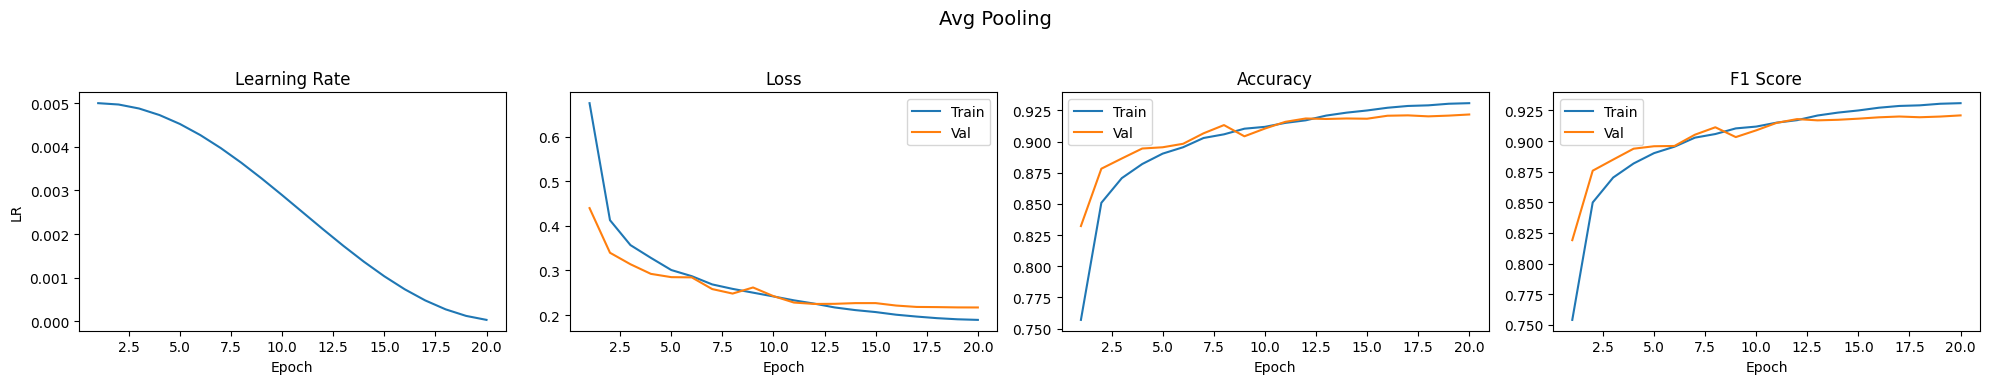

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.2499
Test Accuracy:  0.9107
Test Precision: 0.9104
Test Recall:    0.9107
Test F1-score:  0.9105
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─Identity: 2-2                     [1, 8, 28, 28]            --
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
│    └─AvgPool2d: 2-4                    [1, 8, 14, 14]            --
│    └─Dropout2d: 2-5                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 16, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 16, 14, 14]           1,168
│    └─Identity: 2-7                     [1, 16, 14, 14]           --
│    └─ReLU: 2-8                    

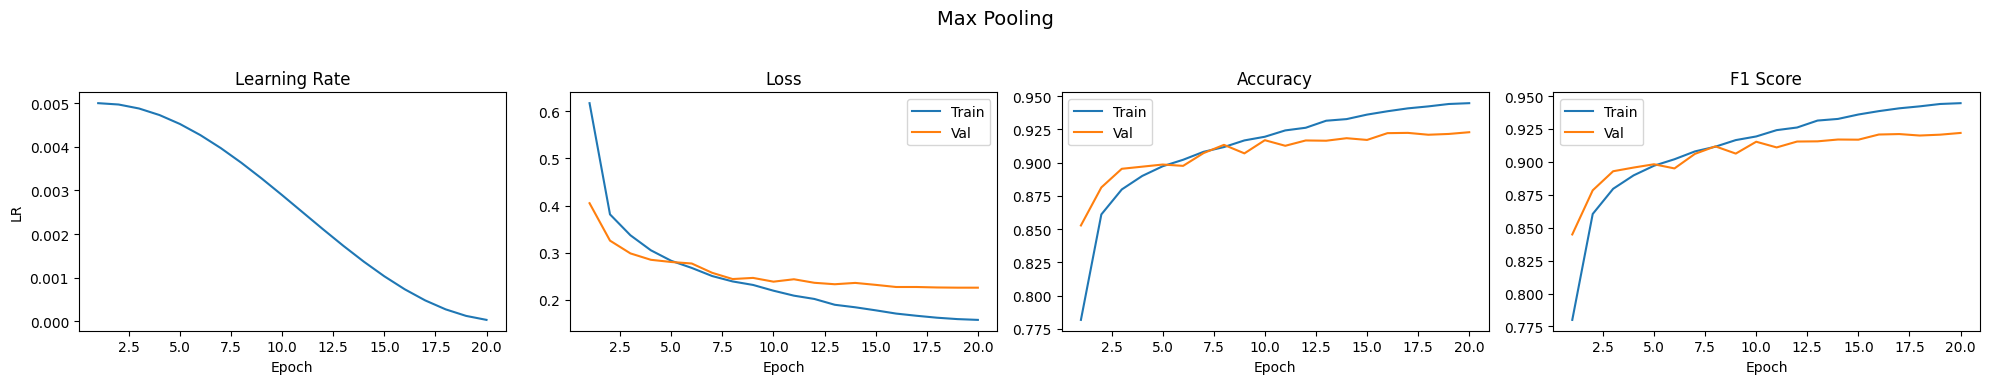

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.2652
Test Accuracy:  0.9050
Test Precision: 0.9045
Test Recall:    0.9050
Test F1-score:  0.9047
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─Identity: 2-2                     [1, 8, 28, 28]            --
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
│    └─Dropout2d: 2-5                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 16, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 16, 14, 14]           1,168
│    └─Identity: 2-7                     [1, 16, 14, 14]           --
│    └─ReLU: 2-8                    

In [ ]:
#Avg pooling
testParams(text="Avg Pooling", pooling = nn.AvgPool2d)

#Max pooling
testParams("Max Pooling", pooling = nn.MaxPool2d)


Max Pooling radził sobie lepiej na zbiorze treningowym, ale na zbiorach walidacyjnym i testowym wypadł gorzej od Average Poolingu. Wydaje mi się że szybciej zaczął dla niego zachodzić overfitting.

Global Average Pooling
Epoch [1/20] | LR:0.005000 | Train L:1.4510 A:0.4436 F1:0.4328 | Val L:1.0440 A:0.5989 F1:0.5831
Epoch [2/20] | LR:0.004969 | Train L:0.9753 A:0.6316 F1:0.6289 | Val L:0.8915 A:0.6784 F1:0.6725
Epoch [3/20] | LR:0.004878 | Train L:0.8863 A:0.6703 F1:0.6677 | Val L:0.8209 A:0.7014 F1:0.7003
Epoch [4/20] | LR:0.004728 | Train L:0.8280 A:0.6912 F1:0.6887 | Val L:0.7808 A:0.7105 F1:0.7074
Epoch [5/20] | LR:0.004523 | Train L:0.7948 A:0.7037 F1:0.7010 | Val L:0.7489 A:0.7256 F1:0.7254
Epoch [6/20] | LR:0.004268 | Train L:0.7643 A:0.7149 F1:0.7122 | Val L:0.7407 A:0.7276 F1:0.7225
Epoch [7/20] | LR:0.003970 | Train L:0.7414 A:0.7225 F1:0.7193 | Val L:0.7152 A:0.7382 F1:0.7303
Epoch [8/20] | LR:0.003635 | Train L:0.7173 A:0.7351 F1:0.7318 | Val L:0.6856 A:0.7538 F1:0.7459
Epoch [9/20] | LR:0.003273 | Train L:0.6994 A:0.7427 F1:0.7391 | Val L:0.6801 A:0.7502 F1:0.7462
Epoch [10/20] | LR:0.002892 | Train L:0.6919 A:0.7432 F1:0.7393 | Val L:0.6651 A:0.7600 F1:0.7543
Epoch 

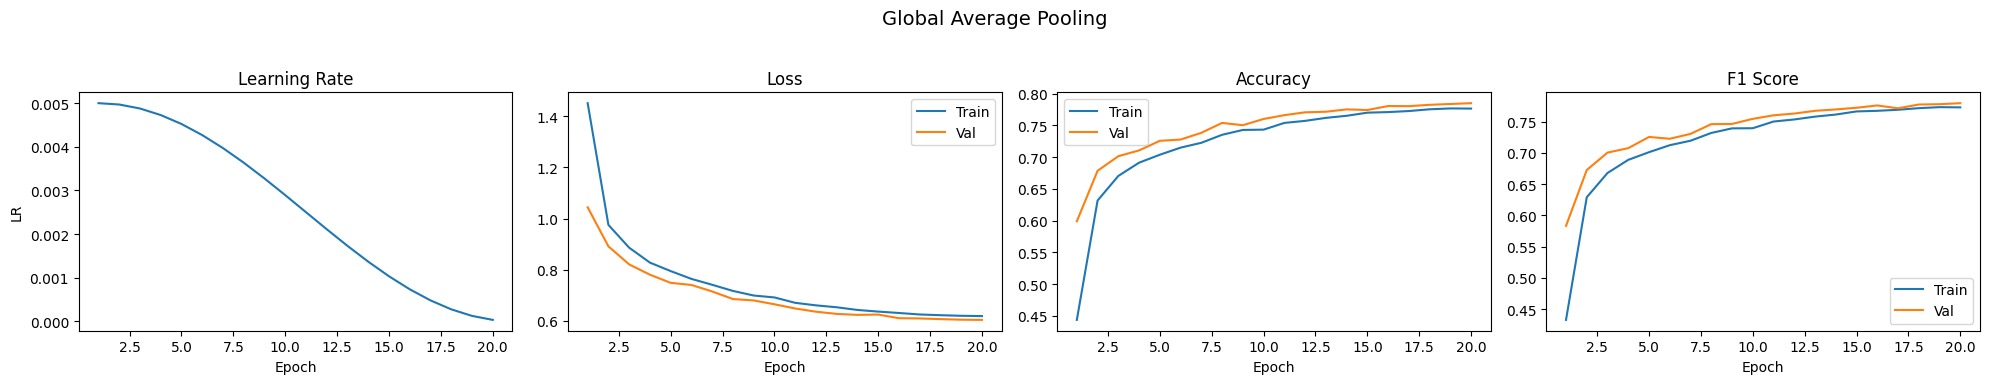

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.6389
Test Accuracy:  0.7694
Test Precision: 0.7639
Test Recall:    0.7694
Test F1-score:  0.7654
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─Identity: 2-2                     [1, 8, 28, 28]            --
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
│    └─Dropout2d: 2-5                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 16, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 16, 14, 14]           1,168
│    └─Identity: 2-7                     [1, 16, 14, 14]           --
│    └─ReLU: 2-8                    

In [ ]:

#GAP
testParams("Global Average Pooling", pooling = nn.MaxPool2d, global_average_pooling=True)


Dodanie Global Average Poolingu znacznie pogorszyło wyniki

Batchnorm
Epoch [1/20] | LR:0.005000 | Train L:1.1675 A:0.5922 F1:0.5848 | Val L:0.8222 A:0.7117 F1:0.6947
Epoch [2/20] | LR:0.004969 | Train L:0.7479 A:0.7320 F1:0.7233 | Val L:0.6830 A:0.7643 F1:0.7544
Epoch [3/20] | LR:0.004878 | Train L:0.6597 A:0.7599 F1:0.7530 | Val L:0.6368 A:0.7801 F1:0.7752
Epoch [4/20] | LR:0.004728 | Train L:0.6110 A:0.7776 F1:0.7731 | Val L:0.8361 A:0.6849 F1:0.6606
Epoch [5/20] | LR:0.004523 | Train L:0.5781 A:0.7913 F1:0.7877 | Val L:0.6927 A:0.7528 F1:0.7453
Epoch [6/20] | LR:0.004268 | Train L:0.5513 A:0.8012 F1:0.7987 | Val L:0.5745 A:0.7977 F1:0.7947
Epoch [7/20] | LR:0.003970 | Train L:0.5287 A:0.8105 F1:0.8080 | Val L:0.6913 A:0.7428 F1:0.7396
Epoch [8/20] | LR:0.003635 | Train L:0.5157 A:0.8165 F1:0.8144 | Val L:0.8642 A:0.6803 F1:0.6695
Epoch [9/20] | LR:0.003273 | Train L:0.5041 A:0.8202 F1:0.8183 | Val L:0.5278 A:0.8119 F1:0.8121
Epoch [10/20] | LR:0.002892 | Train L:0.4943 A:0.8239 F1:0.8224 | Val L:0.5096 A:0.8202 F1:0.8185
Epoch [11/20] | LR:

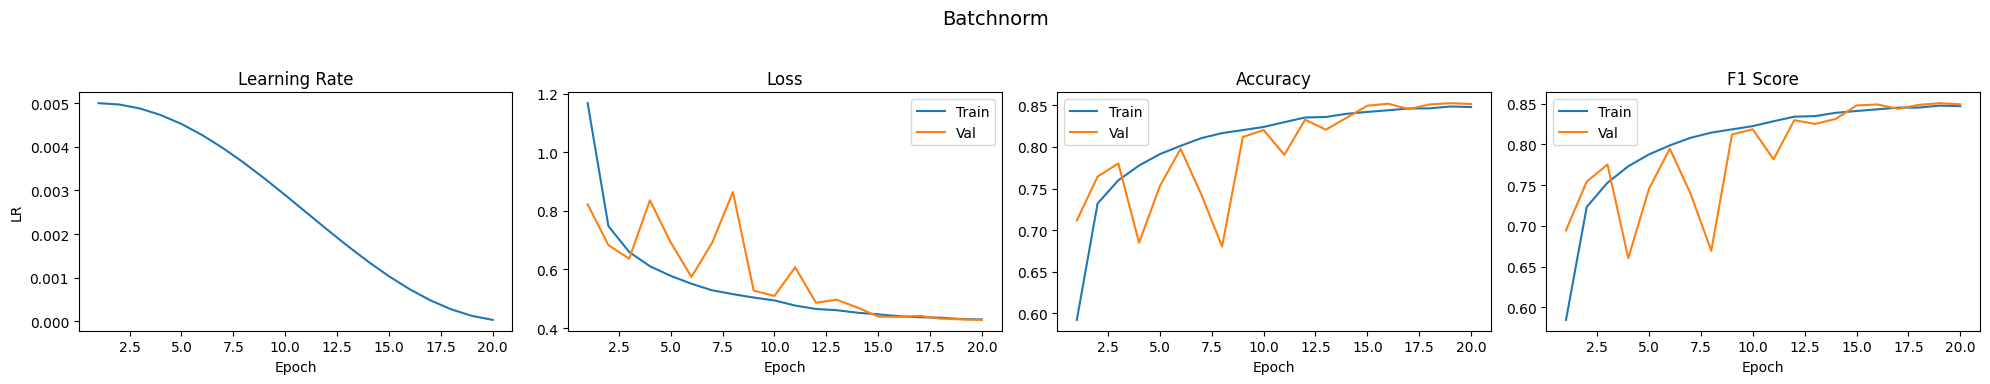

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.4582
Test Accuracy:  0.8394
Test Precision: 0.8379
Test Recall:    0.8394
Test F1-score:  0.8382
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 28, 28]            16
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
│    └─Dropout2d: 2-5                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 16, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 16, 14, 14]           1,168
│    └─BatchNorm2d: 2-7                  [1, 16, 14, 14]           32
│    └─ReLU: 2-8                    

In [ ]:

#batchnorm
testParams("Batchnorm", pooling = nn.MaxPool2d, global_average_pooling=True, use_batchnorm=True)


Dodanie batchnorm poprawiło wydajność modelu.

Dropout
Epoch [1/20] | LR:0.005000 | Train L:1.7177 A:0.3295 F1:0.3215 | Val L:1.3529 A:0.4935 F1:0.4695
Epoch [2/20] | LR:0.004969 | Train L:1.3450 A:0.4707 F1:0.4609 | Val L:1.0801 A:0.6162 F1:0.5990
Epoch [3/20] | LR:0.004878 | Train L:1.2467 A:0.5153 F1:0.5047 | Val L:1.0375 A:0.6622 F1:0.6468
Epoch [4/20] | LR:0.004728 | Train L:1.1894 A:0.5420 F1:0.5322 | Val L:0.9447 A:0.6593 F1:0.6326
Epoch [5/20] | LR:0.004523 | Train L:1.1507 A:0.5581 F1:0.5482 | Val L:0.9482 A:0.6884 F1:0.6858
Epoch [6/20] | LR:0.004268 | Train L:1.1130 A:0.5747 F1:0.5668 | Val L:0.9623 A:0.6364 F1:0.6266
Epoch [7/20] | LR:0.003970 | Train L:1.0900 A:0.5856 F1:0.5771 | Val L:0.9538 A:0.6474 F1:0.6343
Epoch [8/20] | LR:0.003635 | Train L:1.0780 A:0.5893 F1:0.5806 | Val L:0.8755 A:0.6961 F1:0.6689
Epoch [9/20] | LR:0.003273 | Train L:1.0633 A:0.5986 F1:0.5891 | Val L:0.9297 A:0.6457 F1:0.6279
Epoch [10/20] | LR:0.002892 | Train L:1.0537 A:0.5999 F1:0.5909 | Val L:0.8901 A:0.6704 F1:0.6513
Epoch [11/20] | LR:0.

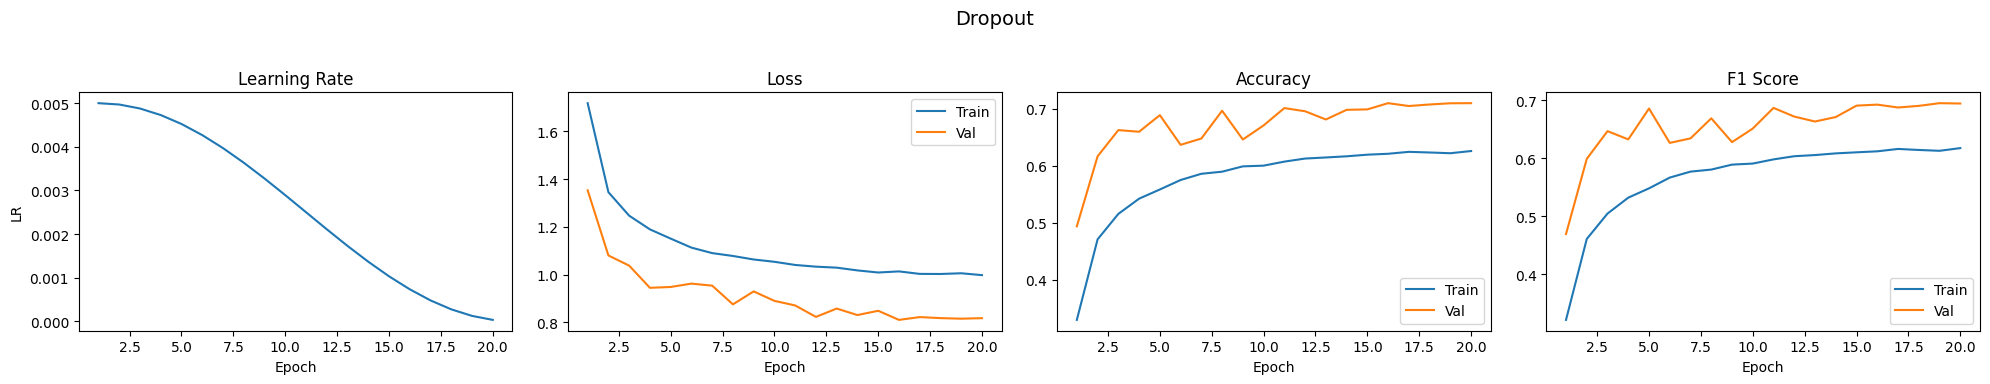

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.8280
Test Accuracy:  0.6992
Test Precision: 0.7156
Test Recall:    0.6992
Test F1-score:  0.6820
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 28, 28]            16
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
│    └─Dropout2d: 2-5                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 16, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 16, 14, 14]           1,168
│    └─BatchNorm2d: 2-7                  [1, 16, 14, 14]           32
│    └─ReLU: 2-8                    

In [ ]:

#dropout
testParams("Dropout", pooling = nn.MaxPool2d, global_average_pooling=True, use_batchnorm=True, dropout_p=0.2)


Dropout również pogorszył skuteczność modelu na zbiorze treningowym, na zbiorach testowym i walidacyjnym trochę mniej. Wydaje mi się że zwiększenie epok mogłoby szczególnie tutaj pomóc zredukować spadek wydajności.

Większa sieć
Epoch [1/20] | LR:0.005000 | Train L:1.4122 A:0.4512 F1:0.4416 | Val L:0.9488 A:0.6754 F1:0.6468
Epoch [2/20] | LR:0.004969 | Train L:1.0447 A:0.6037 F1:0.5898 | Val L:0.7698 A:0.7232 F1:0.6883
Epoch [3/20] | LR:0.004878 | Train L:0.9429 A:0.6465 F1:0.6327 | Val L:0.7240 A:0.7530 F1:0.7326
Epoch [4/20] | LR:0.004728 | Train L:0.8772 A:0.6734 F1:0.6616 | Val L:0.6833 A:0.7484 F1:0.7279
Epoch [5/20] | LR:0.004523 | Train L:0.8343 A:0.6917 F1:0.6802 | Val L:0.6580 A:0.7665 F1:0.7469
Epoch [6/20] | LR:0.004268 | Train L:0.8035 A:0.7040 F1:0.6942 | Val L:0.6248 A:0.7698 F1:0.7507
Epoch [7/20] | LR:0.003970 | Train L:0.7788 A:0.7129 F1:0.7036 | Val L:0.6145 A:0.7801 F1:0.7672
Epoch [8/20] | LR:0.003635 | Train L:0.7580 A:0.7218 F1:0.7142 | Val L:0.5944 A:0.7753 F1:0.7465
Epoch [9/20] | LR:0.003273 | Train L:0.7394 A:0.7268 F1:0.7191 | Val L:0.6083 A:0.7767 F1:0.7620
Epoch [10/20] | LR:0.002892 | Train L:0.7215 A:0.7352 F1:0.7279 | Val L:0.5694 A:0.7907 F1:0.7797
Epoch [11/20] | 

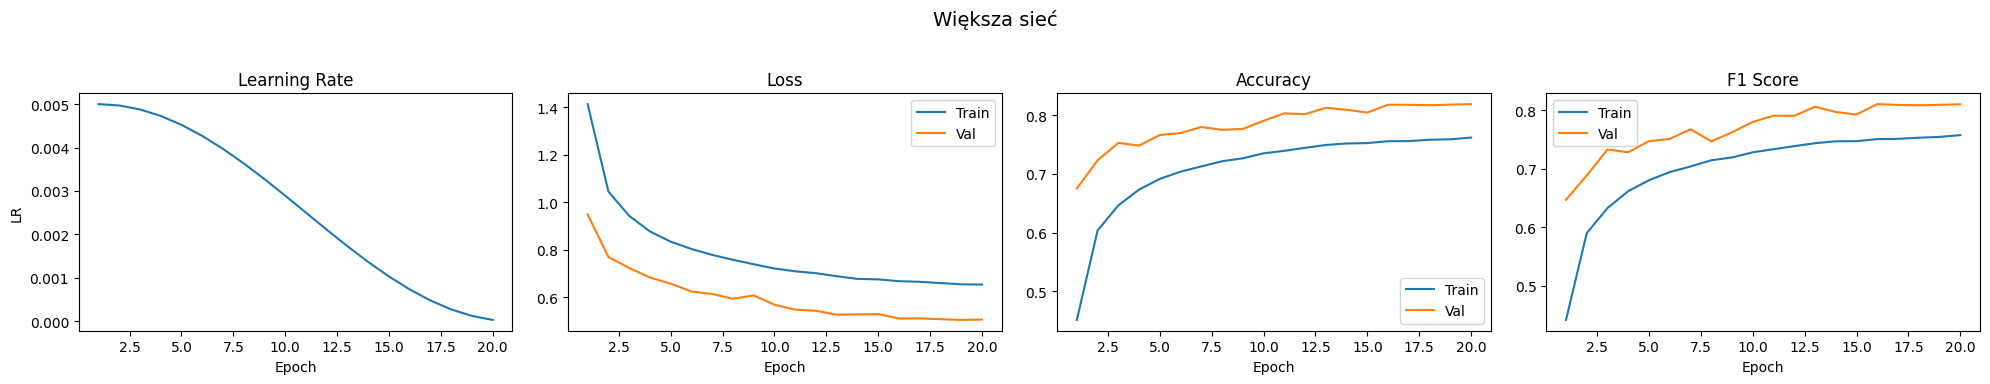

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.5373
Test Accuracy:  0.8042
Test Precision: 0.8031
Test Recall:    0.8042
Test F1-score:  0.7972
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 28, 28]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 28, 28]            16
│    └─ReLU: 2-3                         [1, 8, 28, 28]            --
│    └─Dropout2d: 2-4                    [1, 8, 28, 28]            --
├─Sequential: 1-2                        [1, 16, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 16, 28, 28]           1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 28, 28]           32
│    └─ReLU: 2-7                         [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-8               

In [ ]:
#3 conv layers
testParams("Większa sieć", pooling = nn.MaxPool2d, global_average_pooling=True, use_batchnorm=True, dropout_p=0.2, bigger_network=True)

stride=2
Epoch [1/20] | LR:0.005000 | Train L:0.9335 A:0.6539 F1:0.6462 | Val L:0.5320 A:0.7937 F1:0.7727
Epoch [2/20] | LR:0.004969 | Train L:0.6470 A:0.7633 F1:0.7570 | Val L:0.4638 A:0.8217 F1:0.8148
Epoch [3/20] | LR:0.004878 | Train L:0.5969 A:0.7822 F1:0.7781 | Val L:0.4414 A:0.8310 F1:0.8269
Epoch [4/20] | LR:0.004728 | Train L:0.5670 A:0.7911 F1:0.7871 | Val L:0.4153 A:0.8428 F1:0.8371
Epoch [5/20] | LR:0.004523 | Train L:0.5421 A:0.8017 F1:0.7980 | Val L:0.4040 A:0.8424 F1:0.8379
Epoch [6/20] | LR:0.004268 | Train L:0.5338 A:0.8019 F1:0.7985 | Val L:0.3942 A:0.8480 F1:0.8418
Epoch [7/20] | LR:0.003970 | Train L:0.5185 A:0.8086 F1:0.8055 | Val L:0.3920 A:0.8498 F1:0.8462
Epoch [8/20] | LR:0.003635 | Train L:0.5118 A:0.8107 F1:0.8078 | Val L:0.3850 A:0.8525 F1:0.8448
Epoch [9/20] | LR:0.003273 | Train L:0.5059 A:0.8120 F1:0.8089 | Val L:0.3786 A:0.8554 F1:0.8527
Epoch [10/20] | LR:0.002892 | Train L:0.4967 A:0.8147 F1:0.8119 | Val L:0.3800 A:0.8532 F1:0.8493
Epoch [11/20] | LR:0

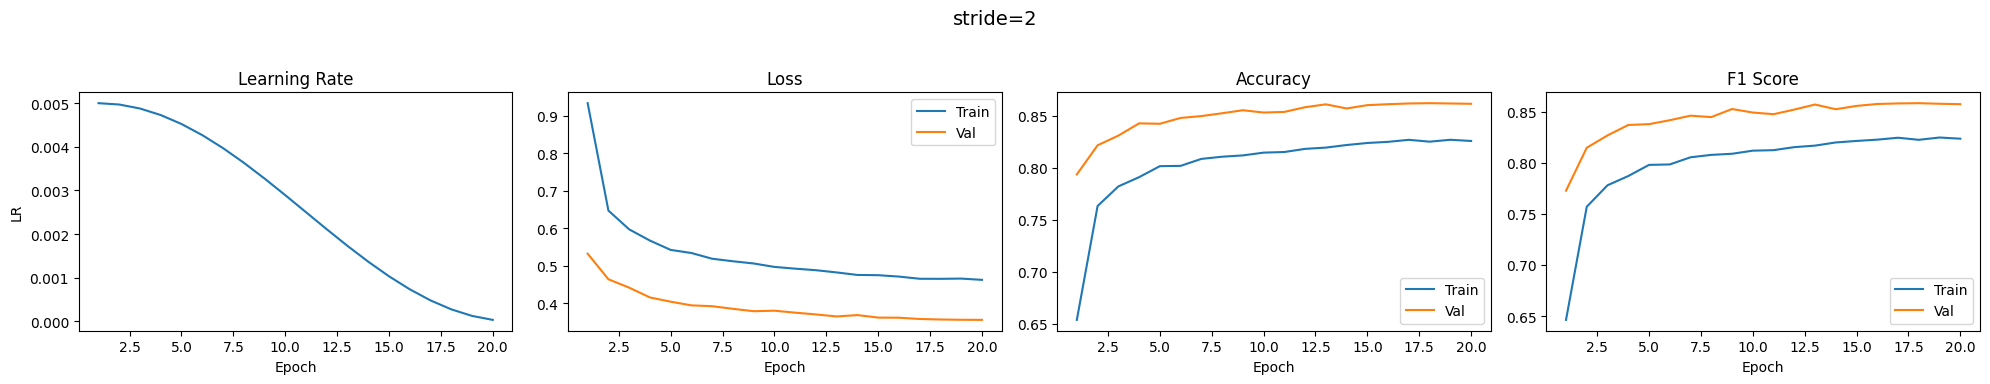

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.3985
Test Accuracy:  0.8472
Test Precision: 0.8445
Test Recall:    0.8472
Test F1-score:  0.8450
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 14, 14]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 14, 14]            16
│    └─ReLU: 2-3                         [1, 8, 14, 14]            --
│    └─Dropout2d: 2-4                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 16, 3, 3]             --
│    └─Conv2d: 2-5                       [1, 16, 7, 7]             1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 7, 7]             32
│    └─ReLU: 2-7                         [1, 16, 7, 7]             --
│    └─MaxPool2d: 2-8               

In [ ]:

#bigger stride
testParams("stride=2", pooling = nn.MaxPool2d, global_average_pooling=True, use_batchnorm=True, dropout_p=0.2, bigger_network=True, stride=2)


dilation=2
Epoch [1/20] | LR:0.005000 | Train L:1.1674 A:0.5494 F1:0.5418 | Val L:0.7207 A:0.7353 F1:0.7171
Epoch [2/20] | LR:0.004969 | Train L:0.8185 A:0.6842 F1:0.6755 | Val L:0.6253 A:0.7612 F1:0.7402
Epoch [3/20] | LR:0.004878 | Train L:0.7439 A:0.7103 F1:0.6984 | Val L:0.5772 A:0.7758 F1:0.7544
Epoch [4/20] | LR:0.004728 | Train L:0.6962 A:0.7307 F1:0.7184 | Val L:0.5469 A:0.7971 F1:0.7821
Epoch [5/20] | LR:0.004523 | Train L:0.6548 A:0.7473 F1:0.7351 | Val L:0.5236 A:0.8041 F1:0.7900
Epoch [6/20] | LR:0.004268 | Train L:0.6352 A:0.7572 F1:0.7478 | Val L:0.4787 A:0.8227 F1:0.8127
Epoch [7/20] | LR:0.003970 | Train L:0.6078 A:0.7700 F1:0.7620 | Val L:0.4776 A:0.8309 F1:0.8257
Epoch [8/20] | LR:0.003635 | Train L:0.5939 A:0.7763 F1:0.7707 | Val L:0.4568 A:0.8284 F1:0.8167
Epoch [9/20] | LR:0.003273 | Train L:0.5754 A:0.7841 F1:0.7785 | Val L:0.4453 A:0.8444 F1:0.8386
Epoch [10/20] | LR:0.002892 | Train L:0.5673 A:0.7895 F1:0.7843 | Val L:0.4399 A:0.8420 F1:0.8360
Epoch [11/20] | LR

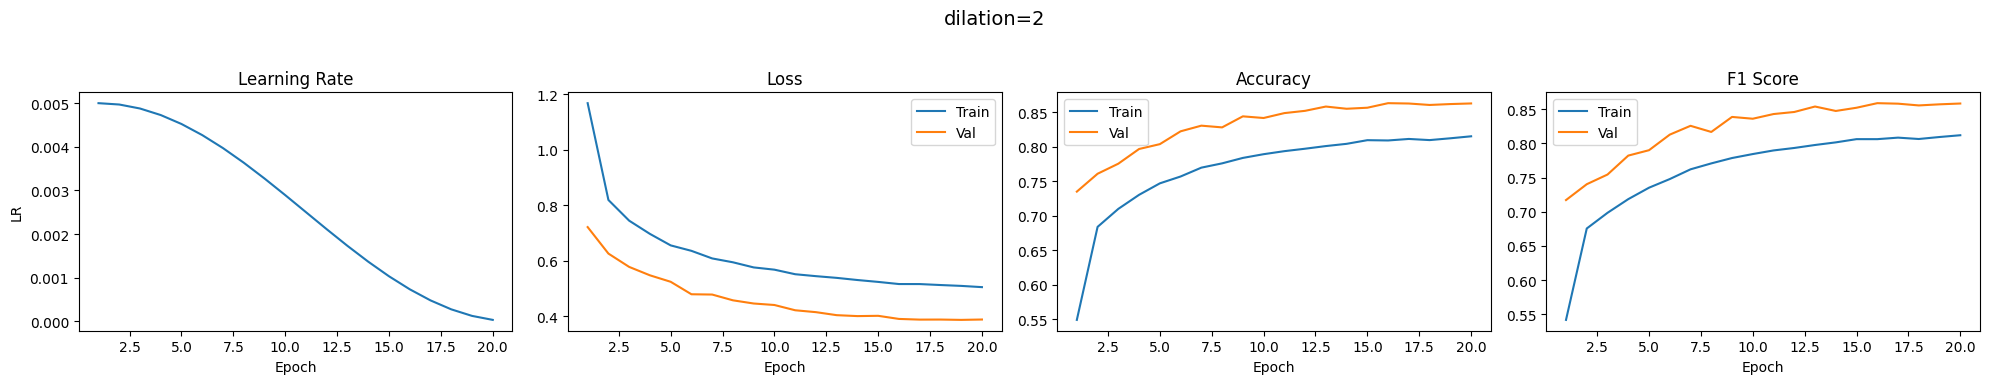

-----ewaluacja modelu:

===== TEST RESULTS =====
Test Loss:      0.4244
Test Accuracy:  0.8454
Test Precision: 0.8436
Test Recall:    0.8454
Test F1-score:  0.8413
-----wielkość modelu:
Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            80
│    └─BatchNorm2d: 2-2                  [1, 8, 26, 26]            16
│    └─ReLU: 2-3                         [1, 8, 26, 26]            --
│    └─Dropout2d: 2-4                    [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 16, 12, 12]           --
│    └─Conv2d: 2-5                       [1, 16, 24, 24]           1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 24, 24]           32
│    └─ReLU: 2-7                         [1, 16, 24, 24]           --
│    └─MaxPool2d: 2-8               

In [ ]:

#bigger dilation
testParams("dilation=2", pooling = nn.MaxPool2d, global_average_pooling=True, use_batchnorm=True, dropout_p=0.2, bigger_network=True, dilation=2)


Zarówno stride jak i dilation poprawiły wydajność sieci, czego się nie spodziewałem.

### *Zadanie 5 (dla chętnych)

Wykorzystaj [CAM](https://zilliz.com/learn/class-activation-mapping-CAM) do wizualizacji aktywacji konwolucji dla kilku przykładów ze zbioru testowego. Do tego celu twoja sieć musi koniecznie mieć warstwę Global Avg Pooling, a końcowy moduł FNN być jednowarstwowy.